In [1]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from matplotlib import gridspec

from sklearn.preprocessing import scale

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from torch.utils.data import Dataset

from sklearn.utils import shuffle
from scipy.special import softmax

from PIL import Image

from PIL import ImageDraw

from skimage import morphology

import pickle

In [20]:
from MixtureLib.Mixture import MixtureEM
from MixtureLib.LocalModels import EachModelLinear, EachModel
from MixtureLib.HyperModels import HyperExpertNN, HyperModelDirichlet

from MixtureLib.Regularizers import RegularizeModel

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Circle model

In [ ]:
class EachModelUniform(EachModel):
    def __init__(self, input_dim = 20, device = 'cpu', A = None, w = None):
        super(EachModelLinear, self).__init__()

        self.input_dim = input_dim
        self.device = device
        
        self.A = A
            
        self.W = (1e-5)*torch.randn(input_dim, 1, device = self.device)
        
        if w is not None:
            self.w_0 = w.clone()
            self.W.data = w.data.clone() + (1e-5)*torch.randn(input_dim, 1, device = self.device)
        else:
            self.w_0 = w
        
        self.B = torch.eye(input_dim, device = self.device)
        if self.A is not None:
            if len(self.A.shape) == 1:
                self.B.data = torch.diag(self.A).data.clone()
            else:
                self.B.data = self.A.data.clone()
        
    def forward(self, input):
        return input@self.W
    
    def OptimizeHyperParameters(self, X, Y, Z, HyperParameters, Parameter):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        Parameter is a Key in dictionary
        """
        pass
        
    def LogLikeLihoodExpectation(self, X, Y, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        beta = 1./(HyperParameters['beta'] + 0.000001)
        temp1 = Y**2
        temp2 = -2*Y*(X@self.W)
        temp3 = torch.diagonal(X@(self.B+self.W@self.W.transpose(0,1))@X.transpose(0,1)).view([-1, 1])
        return (-0.5*beta*(temp1 + temp2 + temp3) + 0.5*math.log(beta/(2*math.pi))).detach()
        

    def E_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        beta = 1./(HyperParameters['beta'] + 0.000001)
        temp = X.unsqueeze(2)
        
        if self.A is None:
            self.B = torch.inverse(((temp*Z.unsqueeze(1))@temp.transpose(2, 1)).sum(dim = 0)).detach()
            second = (X*Y*Z).sum(dim = 0).view([-1, 1])
            self.W.data = (self.B@second).view_as(self.W).detach()
        else:
            A = self.A
            if len(self.A.shape) == 1:
                A = torch.diag(self.A)
            try:
                A_inv = torch.inverse(A)
            except:
                A_inv = (2**32)*torch.eye(A.shape[0])
            
            self.B = torch.inverse(A_inv + beta*((temp*Z.unsqueeze(1))@temp.transpose(2, 1)).sum(dim = 0)).detach()
            second = beta*(X*Y*Z).sum(dim = 0).view([-1, 1])       
            if self.w_0 is None:
                self.W.data = ((self.B@second)).view_as(self.W).detach()
            else:
                self.W.data = (self.B@(second + A_inv@self.w_0)).view_as(self.W).detach()
        
        return

    def M_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        beta = 1./(HyperParameters['beta'] + 0.000001)
        
        if self.A is not None:
            if self.w_0 is not None:
                if len(self.A.shape) == 1:
                    self.A= torch.diagonal(self.B+self.W@self.W.transpose(0,1) - self.w_0@self.W.transpose(0,1) - self.W@self.w_0.transpose(0,1) + self.w_0@self.w_0.transpose(0,1)).detach()
                else:
                    self.A= (self.B+self.W@self.W.transpose(0,1) - self.w_0@self.W.transpose(0,1) - self.W@self.w_0.transpose(0,1) + self.w_0@self.w_0.transpose(0,1)).detach()
            else:
                if len(self.A.shape) == 1:
                    self.A = torch.diagonal(self.B+self.W@self.W.transpose(0,1)).detach()
                else:
                    self.A = (self.B+self.W@self.W.transpose(0,1)).detach()
                
        
        if self.w_0 is not None:
            self.w_0.data = self.W.data.clone()

        return

# Experiment EM-ensamble

In [138]:
np.random.seed(0)
N = 1000
n = 3
r1 = 1

x0 = 0
y0 = 0

phi = np.random.rand(N)*(2*np.pi)
R = np.random.rand(N)*r1 # круг
# R = r1 # окружность

x = R*np.sin(phi) + x0
x += 0.1*np.random.randn(x.shape[0])

y = R*np.cos(phi) + y0
y += 0.1*np.random.randn(y.shape[0])

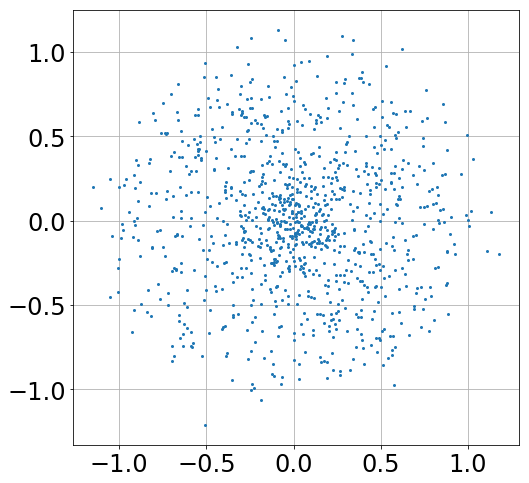

In [139]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

plt.plot(x, y, '.')

plt.grid()

plt.show()

In [140]:
X = np.vstack([x, y, np.ones_like(x)]).T
Y = x**2+y**2

X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(Y).view([-1,1])

X_tr.shape, Y_tr.shape

(torch.Size([1000, 3]), torch.Size([1000, 1]))

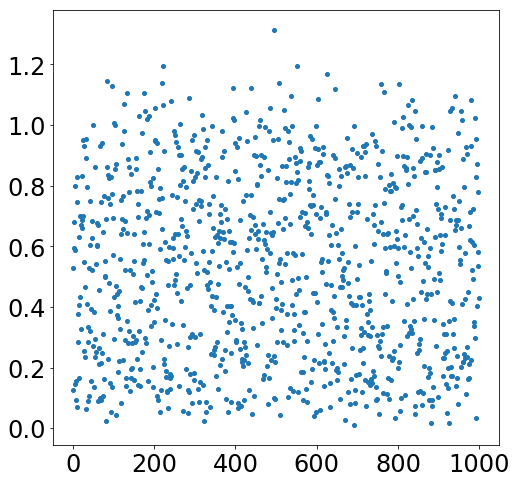

In [141]:
plt.plot(np.sqrt(Y), 'o')

plt.show()

In [120]:
np.max(Y)

1.726817666849025

In [494]:
def sign(x):
    if x >= 0:
        return 1
    else:
        return -1

In [1127]:
def func(x, a=50, beta=1):
    ret = 0
    beta = (0.5*np.pi)**(0.5)/(0.1*a)
    CONST = np.exp(-1./a)*(a+((0.5*np.pi)**(0.5))/beta)
    if 0 < x <= a:
        ret = np.exp(-1./a)
    elif x > a:
        ret = np.exp(-0.5*(beta**2)*(x-a)**2-1./a)
    return ret/CONST

In [1128]:
from scipy import integrate

In [1129]:
integrate.quad(func, 0, 1000)

(1.0000000000005433, 2.0094497177325366e-09)

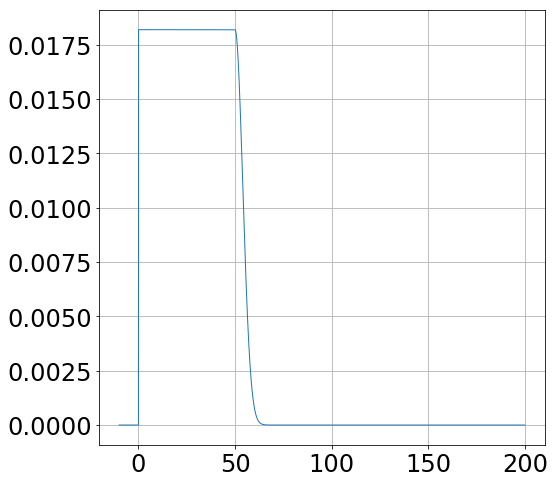

In [1130]:
temp = np.linspace(-10, 200, 10000)
plt.plot(temp, list(map(func, temp)))
plt.grid()
plt.show()

In [1066]:
K = 1
LIST_A = [torch.Tensor([1, 1, 1]) for _ in range(K)]
LIST_w = [torch.Tensor([[0], [0], [1]]), torch.Tensor([[0], [0], [2]])]


LoM = []
for k in range(K):
#     LoM.append(EachModelLinear(input_dim = n, device = device))
    LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.ones(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k]))


HypPar = {'beta': 1.0, 'alpha': 1e-5}

# HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)
HpMd = HyperModelDirichlet(output_dim=K, device=device)

# Rg = RegularizeModel(ListOfModels = LoM, device=device)

# model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, ListOfRegularizeModel = [Rg], device = device)
model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, ListOfRegularizeModel = [], device = device)


In [109]:
%%time
model.fit(X_tr, Y_tr, 25, progress = tqdm)


CPU times: user 160 ms, sys: 9.67 ms, total: 170 ms
Wall time: 148 ms


In [110]:
model.HyperParameters

{'beta': tensor(0.1129), 'alpha': tensor(1.0000e-05)}

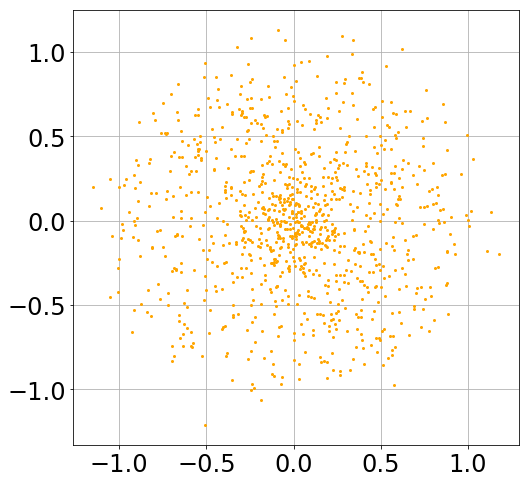

In [111]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

idx = np.argmax(model.predict(X_tr)[1], axis = 1)
t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yellow', 'blue']

for i in np.unique(idx):
    _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i])
    
plt.grid()
plt.show()

In [112]:
TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

TEMP

array([[-0.02513572,  0.00600372,  0.37404346]], dtype=float32)

In [113]:
CIRCLE = np.zeros_like(TEMP)

for i, param in enumerate(TEMP):
    x0, y0 = 0.5*param[:2]
    r = (param[2] + x0**2 + y0**2)**0.5
    CIRCLE[i] = x0, y0, r
    
CIRCLE

array([[-0.01256786,  0.00300186,  0.6117274 ]], dtype=float32)

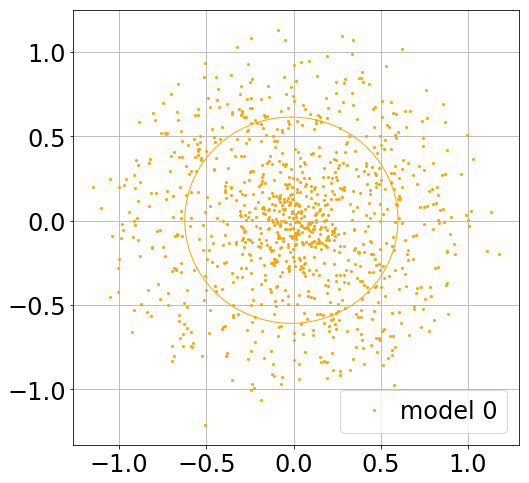

In [114]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

idx = np.argmax(model.predict(X_tr)[1], axis = 1)
t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yellow', 'blue']

for i in range(len(model.ListOfModels)):
    _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))
    
    x0, y0, r = CIRCLE[i]
    x_plot = x0 + r*np.sin(t)
    y_plot = y0 + r*np.cos(t)
    
    _ = plt.plot(x_plot, y_plot, '-', color = colors[i])
    
plt.grid()

plt.legend(loc = 'best')

plt.show()